# **Test A/B**

## Introducción 

En este proyecto se parte de las especificaciones técnicas y los resultados de las pruebas realizadas por quienes precedieron este trabajo. El fin del mismo es comprobar si se ha realizado correctamente la prueba y analizar los resultados.


### Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


## Descripción de los datos

#### Diccionario de datos

* `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020

    - `name`: el nombre del evento de marketing
    - `regions`: regiones donde se llevará a cabo la campaña publicitaria
    - `start_dt`: fecha de inicio de la campaña
    - `finish_dt`: fecha de finalización de la campaña

* `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020

    - `user_id`
    - `first_date`: fecha de inscripción
    - `region`
    - `device`: dispositivo utilizado para la inscripción
* `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021

    - `user_id`
    - `event_dt`: fecha y hora del evento
    - `event_name`: nombre del tipo de evento
    - `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

*  `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

    - `user_id`
    - `ab_test`: nombre de la prueba
    - `group`: el grupo de prueba al que pertenecía el usuario

In [ ]:
#importamos librerías

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import math as mth

In [2787]:
#cargamos los datasets

marketing_events = pd.read_csv('datasets/ab_project_marketing_events_us.csv')
events = pd.read_csv('datasets/final_ab_events_upd_us.csv')
new_users = pd.read_csv('datasets/final_ab_new_users_upd_us.csv')
participants = pd.read_csv('datasets/final_ab_participants_upd_us.csv')

In [2788]:
#observamos lineas random de los datasets y su información general
display(marketing_events.sample(5))
print(f"""
Cantidad de datos duplicados: {marketing_events.duplicated().sum()}
""")
print(marketing_events.info())

,name,regions,start_dt,finish_dt
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03



Cantidad de datos duplicados: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None


In [2789]:
display(events.sample(5))
print(f"""
Cantidad de datos duplicados: {events.duplicated().sum()}
    """)

print(events.info())

,user_id,event_dt,event_name,details
33000,74A35B1C714CAC6D,2020-12-19 03:07:12,purchase,99.99
234893,D674401804EB23CD,2020-12-27 16:04:03,product_page,NaN
110258,796A12EEF9D0C7C3,2020-12-23 09:58:49,product_cart,NaN
174085,E8BBE017F65D7CEA,2020-12-17 01:04:04,product_page,NaN
332683,F546EBF76CCA223D,2020-12-18 06:09:02,login,NaN



Cantidad de datos duplicados: 0
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


In [2790]:
display(new_users.sample(5))
print(f"""
Cantidad de datos duplicados: {new_users.duplicated().sum()}
""")
print(new_users.info())

,user_id,first_date,region,device
17587,0D285C0161DC93C3,2020-12-08,EU,PC
28538,A5691EE66CDA977F,2020-12-16,EU,Android
20567,964CF6A6141C27A9,2020-12-15,EU,PC
2753,A6447776C87FDACC,2020-12-07,EU,PC
35742,7F249C9AB2EA8BD9,2020-12-17,N.America,Android



Cantidad de datos duplicados: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


In [2791]:
display(participants.sample(5))
print(f"""
Cantidad de datos duplicados: {participants.duplicated().sum()}
""")
print(participants.info())

,user_id,group,ab_test
9490,86730AB1A1A65F69,A,interface_eu_test
2778,2E317B5455F674AD,A,recommender_system_test
8840,C88FB46B4576B61D,A,interface_eu_test
13168,F9ADCF4F7C0621E8,A,interface_eu_test
2227,5A455EC25EC9295A,A,recommender_system_test



Cantidad de datos duplicados: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


Primeras observaciones, se observan gran cantidad de datos nulos en el DF Events en la columna 'details'. Además en las columnas con fechas el tipo de dato es 'object' y los cuales serán transformados al tipo datetime.

En el DF 'participants' se observan dos tipos de prueba A/B: una llamada Interface EU y la otra Recommender System.

Dentro de la descripción técnica se observó que el nombre de la prueba era 'recommender_system_test', pero además habla de un 15% de aumento de usuarios europeos con lo cuál puede hacer referencia a la otra prueba A/B que se menciona. Vamos a analizar esto en EDA.

### Preprocesamiento de datos

In [2792]:
#creamos una función para cambiar el tipo de dato a datetime
def to_datetime(df, column, format='%Y-%m-%d'):
    df[column] = pd.to_datetime(df[column])


#aplicamos la función a las columnas que contienen fechas
to_datetime(marketing_events, 'start_dt')
to_datetime(marketing_events, 'finish_dt')
to_datetime(events, 'event_dt', format='%Y-%m-%d %H:%M:%S')
to_datetime(new_users, 'first_date')

# Creamos una columna 'date' con solo la fecha (sin la hora)
events['date'] = events['event_dt'].dt.date

In [2793]:
#observo cantidad de datos nulos en la columna details del DF Events
print('eventos nulos: ', events['details'].isna().sum())

#observo la cantidad de datos nulos por tipo de evento en los que no se registraron detalles
print(events[events['details'].isna()]['event_name'].value_counts())

eventos nulos:  363447
event_name
login           182465
product_page    120862
product_cart     60120
Name: count, dtype: int64


Puede observarse que en la columna details los valores nulos se deben a que no existe en ese evento una compra efectuada, con lo cual se rellena con un NaN. Vamos a cambiar este valor por 0.

In [2794]:
#Reemplazamos NaN por 0 en la columna details
events['details'] = events['details'].fillna(0)


### EDA: Análisis exploratorio de los datos

In [2795]:
#Combinamos los datasets de eventos y de participantes para poder luego compararlos
events_cohort = events.merge(participants[['user_id', 'group', 'ab_test']], on='user_id', how='right')

#creo otro DF donde obtengo las regiones de los usuarios
events_cohort_region = events_cohort.merge(new_users[['user_id', 'region']], on='user_id', how='inner')

#observo como se dividen los usuarios por tipo de prueba, grupo de prueba y region
print(events_cohort_region[['region','ab_test','group']].value_counts())


region     ab_test                  group
EU         interface_eu_test        A        40078
                                    B        38851
           recommender_system_test  A        17670
                                    B         5004
N.America  recommender_system_test  A          679
APAC       recommender_system_test  A          153
CIS        recommender_system_test  A          125
N.America  recommender_system_test  B          125
CIS        recommender_system_test  B           81
APAC       recommender_system_test  B           72
Name: count, dtype: int64


Se puede ver que en la prueba Interface EU la región es únicamente europera. Mientras que las pruebas de Recommender System, se observa que hay registro de otras regiones además. La mayor cantidad de registros proviene de EU y parecen estar dentro de las pruebas A/B de Interface EU.

In [2796]:
#Cúantos eventos hay en los registros:
print('cantidad de eventos únicos registrados: ', events_cohort['event_name'].nunique())

#Cúantos eventos hay en los registros por grupo:
print('cantidad de eventos únicos registrados en grupo A: ', events_cohort[events_cohort['group'] == 'A']['event_name'].nunique())
print('cantidad de eventos únicos registrados en grupo B: ', events_cohort[events_cohort['group'] == 'B']['event_name'].nunique())
print('')

#cantidad de usuarios únicos:
print('cantidad de usuarios únicos: ', events_cohort['user_id'].nunique())
#cantidad de usuarios únicos por grupo:
print('cantidad de usuarios únicos en grupo A: ', events_cohort[events_cohort['group'] == 'A']['user_id'].nunique())
print('cantidad de usuarios únicos en grupo B: ', events_cohort[events_cohort['group'] == 'B']['user_id'].nunique())
print('')

#cantidad de usuarios por tipo de prueba
print('cantidad de pruebas:', events_cohort['ab_test'].nunique())

#cantidad de usuarios únicos por tipo de prueba a/b:
print('cantidad de usuarios únicos en la prueba Recommender System: ', events_cohort[events_cohort['ab_test'] == 'recommender_system_test']['user_id'].nunique())
print('cantidad de usuarios únicos en la prueba Interface EU: ', events_cohort[events_cohort['ab_test'] == 'interface_eu_test']['user_id'].nunique())

cantidad de eventos únicos registrados:  4
cantidad de eventos únicos registrados en grupo A:  4
cantidad de eventos únicos registrados en grupo B:  4

cantidad de usuarios únicos:  13638
cantidad de usuarios únicos en grupo A:  7874
cantidad de usuarios únicos en grupo B:  6205

cantidad de pruebas: 2
cantidad de usuarios únicos en la prueba Recommender System:  3675
cantidad de usuarios únicos en la prueba Interface EU:  10850


#### Prueba: Recommender System

In [2857]:
#separamos el data set con el test 'system recommender' que es el que nos interesa
events_cohort_system = events_cohort[events_cohort['ab_test'] == 'recommender_system_test']
#separamos los data sets en grupo A y B para luego graficar
events_A_system = events_cohort_system[events_cohort_system['group'] == 'A']
events_B_system = events_cohort_system[events_cohort_system['group'] == 'B']

In [2858]:
#creamos un df donde observamos cantidad de eventos por usuario
event_user_system = events_cohort_system.groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
event_user_system.columns = ['user_system', 'events_amount_system']
#observamos las estadisticas con describe de cantidad de eventos por usuario
print(event_user_system['events_amount_system'].describe())

count    3675.00000
mean        6.50585
std         3.69122
min         1.00000
25%         4.00000
50%         6.00000
75%         9.00000
max        28.00000
Name: events_amount_system, dtype: float64


La media d eeventos por usuario es de 6. Con el 75% de usuarios con 9 eventos, 28 pareciera ser un dato anómalo. Vamos separar por tipo de grupo A o B.

In [2859]:
#calculamos la media de eventos por usuario de la prueba Recommender System
user_events_system_A = events_cohort_system[events_cohort_system['group'] == 'A'].groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
user_events_system_A.columns = ['users', 'events_amount']
print('Prueba Recommender System: Grupo A')
print(user_events_system_A.describe())

print("")
#calculamos la media de eventos por usuario de la prueba isystem
user_events_system_B = events_cohort_system[events_cohort_system['group'] == 'B'].groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
user_events_system_B.columns = ['users', 'events_amount']
print('Prueba Recommender System: Grupo B')
print(user_events_system_B.describe())

Prueba Recommender System: Grupo A
       events_amount
count    2747.000000
mean        6.780852
std         3.729768
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000

Prueba Recommender System: Grupo B
       events_amount
count      928.00000
mean         5.69181
std          3.45035
min          1.00000
25%          3.00000
50%          5.00000
75%          8.00000
max         28.00000


La cantidad de eventos en grupo B es menor que en grupo A. Además el promedio de eventos por usuarios es de 5 en grupo B y de 6 en grupo A.

La mayor cantidad de eventos por usuario registrado en grupo A es de 24 y en grupo B es de 28.

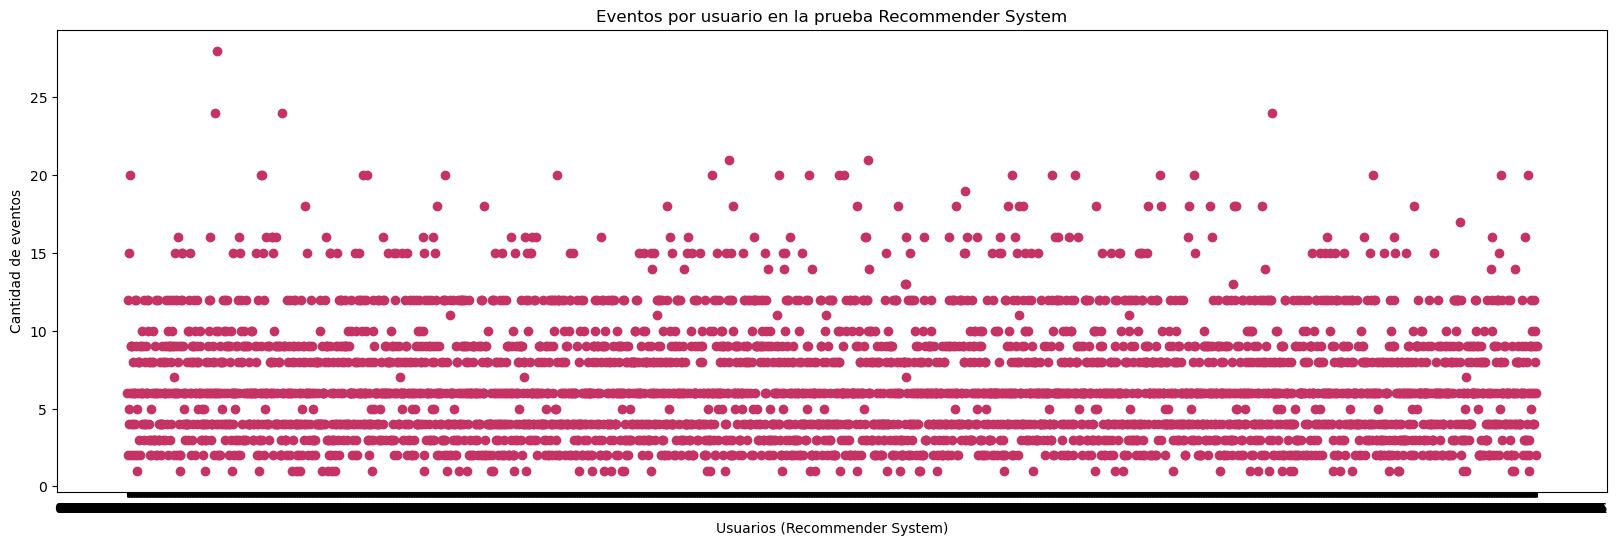

In [2860]:
#graficar para ver mejor la cantidad de evento por usuario
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario en la prueba Recommender System')
plt.scatter(event_user_system['user_system'], event_user_system['events_amount_system'], color="#C53364")
plt.xlabel('Usuarios (Recommender System)')
plt.ylabel('Cantidad de eventos')
plt.show()

In [2861]:
#Calculamos percentiles 95% y 99%
print('Percentiles 95/99:', np.percentile(event_user_system['events_amount_system'],[95, 99]), 'todo lo que supere este último valor es considerado una anomalía')

Percentiles 95/99: [12. 18.] todo lo que supere este último valor es considerado una anomalía


Menos del 5% de usuarios registran más de 12 eventos. Y todos los usuarios que tienen registrados más de 18 eventos son considerados anómalos.

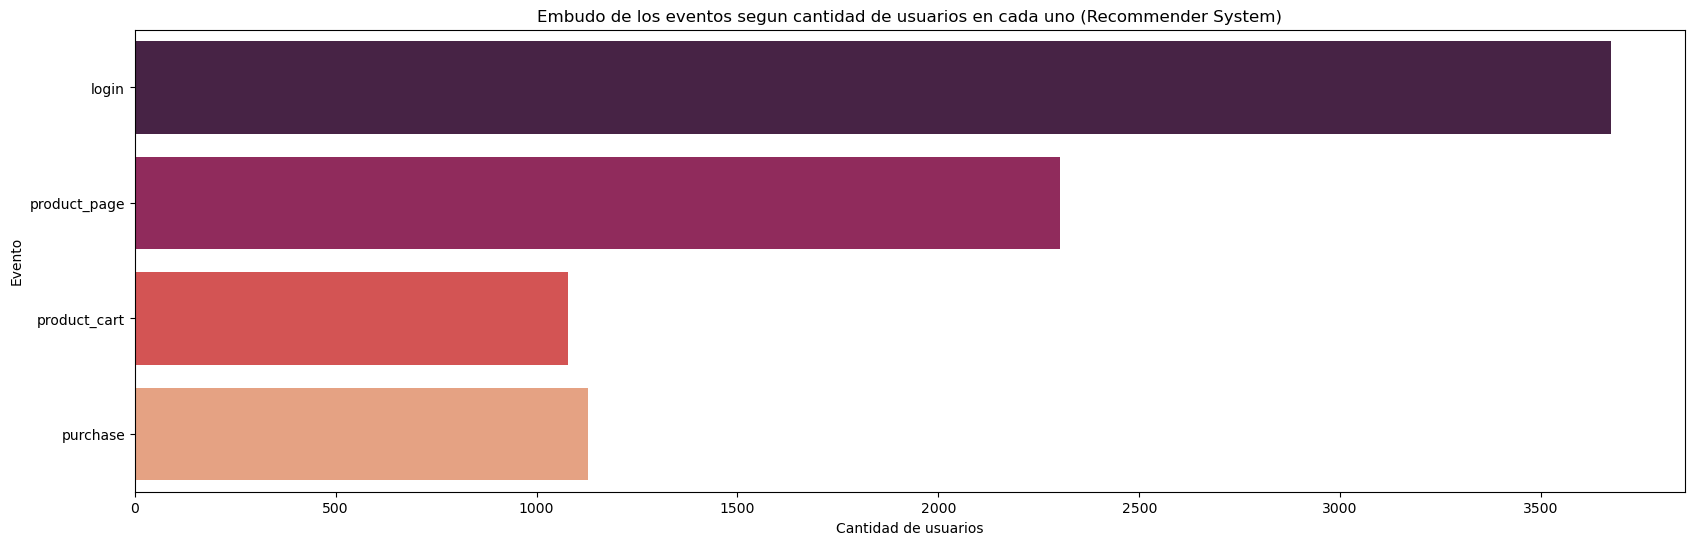

In [2862]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos

events_cohort_total_system = events_cohort_system.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=events_cohort_total_system, y='event_name', x='user_id',  palette='rocket', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios')
plt.title('Embudo de los eventos segun cantidad de usuarios en cada uno (Recommender System)')
sns.color_palette('tab10')
plt.show()

Se observa mayor cantidad en el evento 'purchase' que en el evento previo 'product_card'.

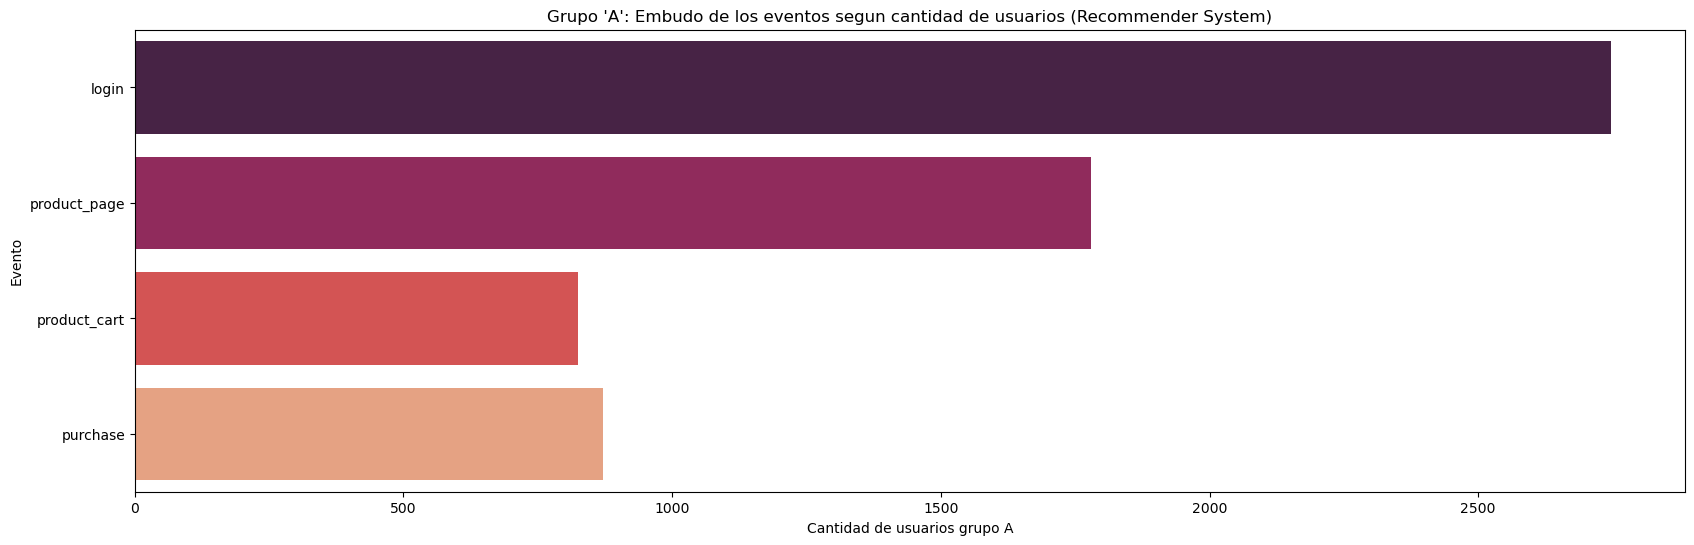

In [2863]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos

cohort_events_A_system = events_A_system.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=cohort_events_A_system, y='event_name', x='user_id', color='purple', palette='rocket', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo A')
plt.title('Grupo \'A\': Embudo de los eventos segun cantidad de usuarios (Recommender System)')
sns.color_palette('tab10')
plt.show()

En el grupo A se observa menor cantidad de usuarios en el evento 'product_cart' que en el que le prosigue.

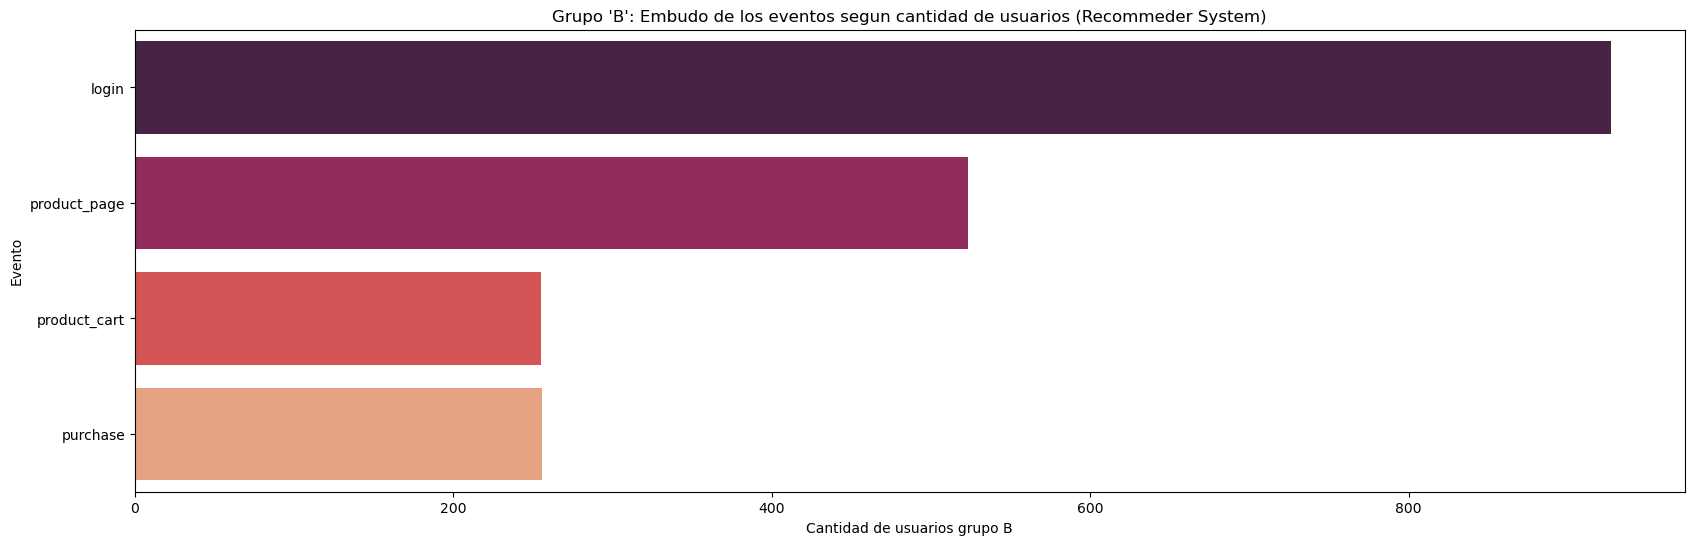

In [2864]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos

cohort_events_B_system = events_B_system.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=cohort_events_B_system, y='event_name', x='user_id', color='purple', palette='rocket', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo B')
plt.title('Grupo \'B\': Embudo de los eventos segun cantidad de usuarios (Recommeder System)')
sns.color_palette('tab10')
plt.show()

In [2865]:
#calculamos cantidad total de usuarios para hacer calculos posteriores:
total_users = events_cohort_system['user_id'].nunique()

users_A = events_A_system['user_id'].nunique()
users_B = events_B_system['user_id'].nunique()

#Calculamos la proporcioón de usuarios que se registraron en cada evento al menos una vez
events_cohort_total_system['user_%'] = (events_cohort_total_system['user_id'] / total_users* 100).round(2)
cohort_events_A_system['user_%'] = (cohort_events_A_system['user_id'] / users_A* 100).round(2)
cohort_events_B_system['user_%'] = (cohort_events_B_system['user_id'] / users_B* 100).round(2)
#Teniendo en cuenta cómo se suceden los eventos, calculamos la tasa de conversion de clientes en cada grupo

events_cohort_total_system['convert_%'] = ((events_cohort_total_system['user_id'] / events_cohort_total_system['user_id'].shift(1))*100).round(2)

#Calculamos la tasa de conversión de usuarios de evento a evento por  cada grupo de prueba
cohort_events_A_system['convert_%'] = ((cohort_events_A_system['user_id'] / cohort_events_A_system['user_id'].shift(1))*100).round(2)
cohort_events_B_system['convert_%'] = ((cohort_events_B_system['user_id'] / cohort_events_B_system['user_id'].shift(1))*100).round(2)

#calculamos la cantidad de usuarios que entre evento y evento se perdieron
events_cohort_total_system['dropped_%'] = 100 - events_cohort_total_system['convert_%']
cohort_events_A_system['dropped_%'] = 100 - cohort_events_A_system['convert_%']
cohort_events_B_system['dropped_%'] = 100 - cohort_events_B_system['convert_%']

print('Eventos y usuarios totales en la prueba Recommender System:')
display(events_cohort_total_system)
print('Grupo A:')
display(cohort_events_A_system)
print('Grupo B:')
display(cohort_events_B_system)

Eventos y usuarios totales en la prueba Recommender System:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,3674,0.0,99.97,NaN,NaN
2,product_page,2303,0.0,62.67,62.68,37.32
1,product_cart,1079,0.0,29.36,46.85,53.15
3,purchase,1128,73592.9,30.69,104.54,-4.54


Grupo A:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,2747,0.00,100.00,NaN,NaN
2,product_page,1780,0.00,64.80,64.80,35.20
1,product_cart,824,0.00,30.00,46.29,53.71
3,purchase,872,58489.55,31.74,105.83,-5.83


Grupo B:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,927,0.00,99.89,NaN,NaN
2,product_page,523,0.00,56.36,56.42,43.58
1,product_cart,255,0.00,27.48,48.76,51.24
3,purchase,256,15103.35,27.59,100.39,-0.39


En las pruebas realizadas en 'recommender_system_test' la cantidad de usuarios fue de 3674 en total, no 6000 como se esperaban. 

El grupo A con un total de 2747 y el grupo B con 927 usuarios, es decir, 3 veces menor.



In [2866]:
#confirmamos que los usuarios en el grupo A y B son únicos y no se repiten en ambos grupos
users_unique_A_system = cohort_events_A_system['user_id'].unique()

users_unique_B_system = cohort_events_B_system['user_id'].unique()

if users_unique_A_system in users_unique_B_system:
    print('Hay usuarios que participaron en ambos grupos de prueba')
else:
    print('No hay usuarios que participaron en ambos grupos de prueba')

No hay usuarios que participaron en ambos grupos de prueba


event_name   login  product_page  product_cart  purchase
date                                                    
2020-12-07   319.0         204.0          81.0     105.0
2020-12-08   278.0         172.0          71.0      72.0
2020-12-09   350.0         212.0          93.0      91.0
2020-12-10   296.0         166.0          79.0      72.0
2020-12-11   274.0         148.0          62.0      58.0
2020-12-12   280.0         147.0          68.0      63.0
2020-12-13   251.0         139.0          52.0      62.0
2020-12-14   619.0         375.0         183.0     178.0
2020-12-15   589.0         358.0         191.0     178.0
2020-12-16   643.0         402.0         205.0     204.0
2020-12-17   677.0         425.0         236.0     210.0
2020-12-18   708.0         455.0         219.0     202.0
2020-12-19   798.0         508.0         256.0     248.0
2020-12-20   830.0         515.0         245.0     258.0
2020-12-21  1089.0         691.0         310.0     351.0
2020-12-22   688.0         427.

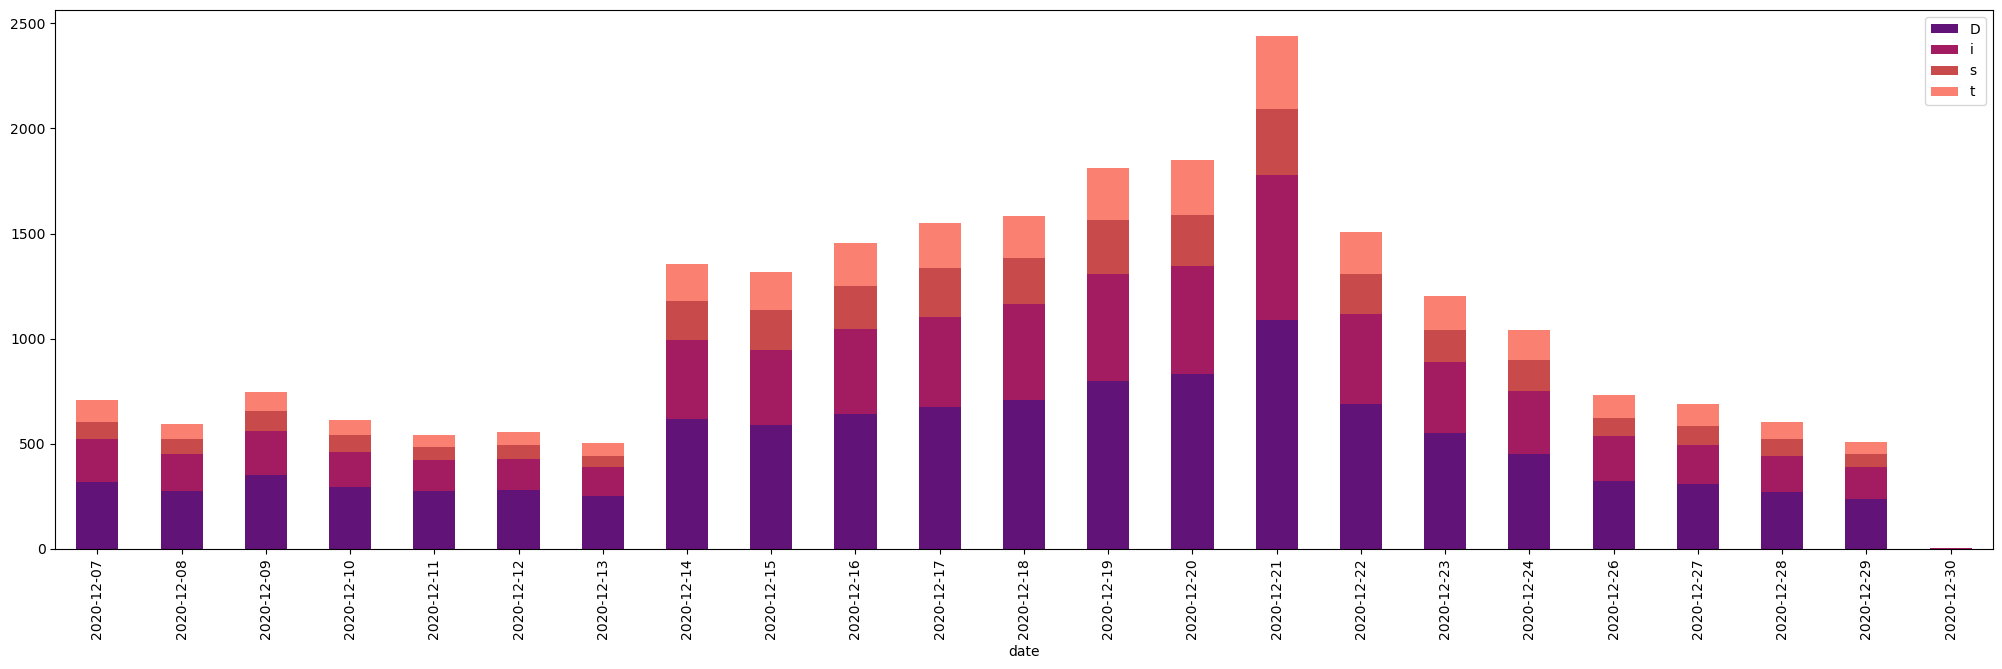

In [2873]:
#Creamos una tabla dinámica para observar cantidad de usuarios por eventos distribuidos a lo largo de los dias
events_pivot_system = events_cohort_system.pivot_table(index='date', columns='event_name', values='user_id', aggfunc='nunique').fillna(0)
events_pivot_system = events_pivot_system[['login', 'product_page', 'product_cart', 'purchase']]
print(events_pivot_system)
events_pivot_system.plot.bar(stacked=True,figsize=(25,7), color=['#621378', "#A31C62", "#C02D2DDC", 'salmon'])
plt.legend('Distribución de los eventos a los largo de los días en la prueba: Recommender System')
plt.show()

(Primero quiero aclarar que los resultados son tipo float porque no se registran usuarios que hayan comprado el 30/12 con lo cual el registro aparece como nulo y esto afecta el tipo de datos utilizados por pivot_table)

Si bien hay un total de más de 14500 participantes, solo 3600 participaron en la prueba 'recommender_system_test', de al menos 6000 que se tenían previstos.

En el grupo A hay 3 veces más participantes que en el grupo B.

Se pueden ver que en el grupo A, en la etapa 'product_cart' hay menos cantidad de usuarios que en la etapa que le sigue donde se finaliza la compra. Esto puede deberse a que el usuario puede 'saltar' esta etapa previa desde 'product_page' o utilizando algún otro atajo. Esta ´particularidad´ hace que en la tabla de conversión se observe en la etapa final, una mayor conversión en el grupo de control a comparación con el grupo de prueba.

En cuanto a la distribución de los eventos del 7/12 al 30/12, puede observarse cómo 10 días previos a navidad, hay gran actividad en todos los eventos. Pero post esta fecha comienza a descender la actividad de los usuarios en cada evento de la plataforma.


### Prueba interface EU test

In [2868]:
#separamos el dataset con el test 'interface_eu_test'
events_cohort_eu = events_cohort[events_cohort ['ab_test'] == 'interface_eu_test']
#separamos los data sets en grupo A y B para luego graficar
events_A_eu = events_cohort_eu[events_cohort_eu['group'] == 'A']
events_B_eu = events_cohort_eu[events_cohort_eu['group'] == 'B']

print(events_cohort_eu.info())

<class 'pandas.core.frame.DataFrame'>
Index: 78929 entries, 23909 to 102837
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     78929 non-null  object        
 1   event_dt    78929 non-null  datetime64[ns]
 2   event_name  78929 non-null  object        
 3   details     78929 non-null  float64       
 4   date        78929 non-null  object        
 5   group       78929 non-null  object        
 6   ab_test     78929 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 4.8+ MB
None


In [2869]:
#creamos un df donde observamos cantidad de eventos por usuario
event_user_eu = events_cohort_eu.groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
event_user_eu.columns = ['user_eu', 'events_amount_eu']
#observamos las estadisticas con describe de cantidad de eventos por usuario
print(event_user_eu['events_amount_eu'].describe())

count    10850.000000
mean         7.274562
std          4.158544
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         32.000000
Name: events_amount_eu, dtype: float64


El promedio de eventos por usuario en las pruebas Interface EU es de 7. 

Teniendo el 75% de usuarios con 7 eventos, 32 pareciera ser un dato anómalo. Vamos separar por tipo de grupo A o B.

In [2870]:
#calculamos la media de eventos por usuario de la prueba interface EU
user_events_eu_A = events_cohort_eu[events_cohort_eu['group'] == 'A'].groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
user_events_eu_A.columns = ['users', 'events_amount']
print('Prueba Interface EU: Grupo A')
print(user_events_eu_A.describe())

print("")
#calculamos la media de eventos por usuario de la prueba interface EU
user_events_eu_B = events_cohort_eu[events_cohort_eu['group'] == 'B'].groupby('user_id')['event_name'].count().reset_index()
#cambiamos el nombre de las columnas
user_events_eu_B.columns = ['users', 'events_amount']
print('Prueba Interface EU: Grupo B')
print(user_events_eu_B.describe())

Prueba Interface EU: Grupo A
       events_amount
count    5467.000000
mean        7.330894
std         4.178342
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        28.000000

Prueba Interface EU: Grupo B
       events_amount
count    5383.000000
mean        7.217351
std         4.137943
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        32.000000


se observa que el promedio y la cantidad de eventos por usuario en ambos grupo es igual hasta el 75%. El máximo de eventos registrados es de 32 en el grupo B y de 28 en el grupo A.

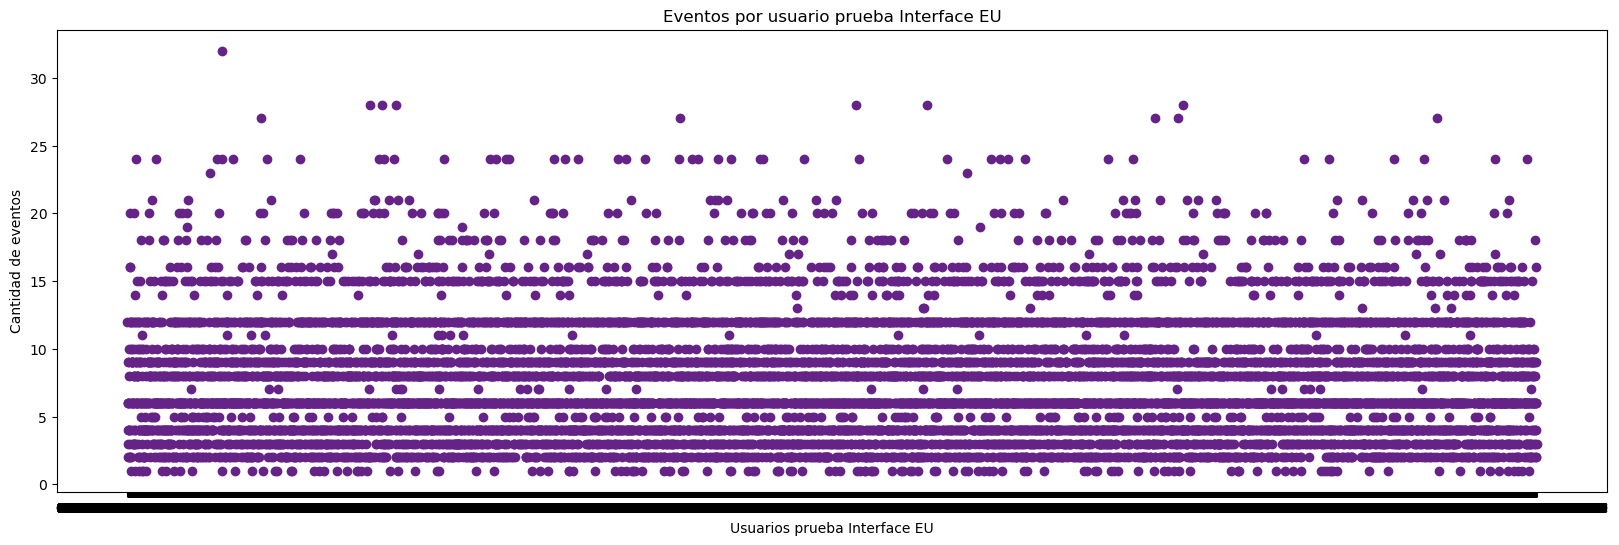

In [2872]:
#graficar para ver mejor la cantidad de evento por usuario
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario prueba Interface EU')
plt.scatter(event_user_eu['user_eu'], event_user_eu['events_amount_eu'], color="#3D1C4E")
plt.xlabel('Usuarios prueba Interface EU')
plt.ylabel('Cantidad de eventos')
plt.show()

In [ ]:
#Calculamos percentiles 95% y 99%
print('Percentiles 95/99:', np.percentile(event_user_eu['events_amount_eu'],[95, 99]), 'todo lo que supere este último valor es considerado una anomalía')

Percentiles 95/99: [15. 20.] todo lo que supere este último valor es considerado una anomalía


Menos del 5% de usuarios registran más de 15 eventos. Todo usuario que posee más de 20 eventos es considerado anómalo.

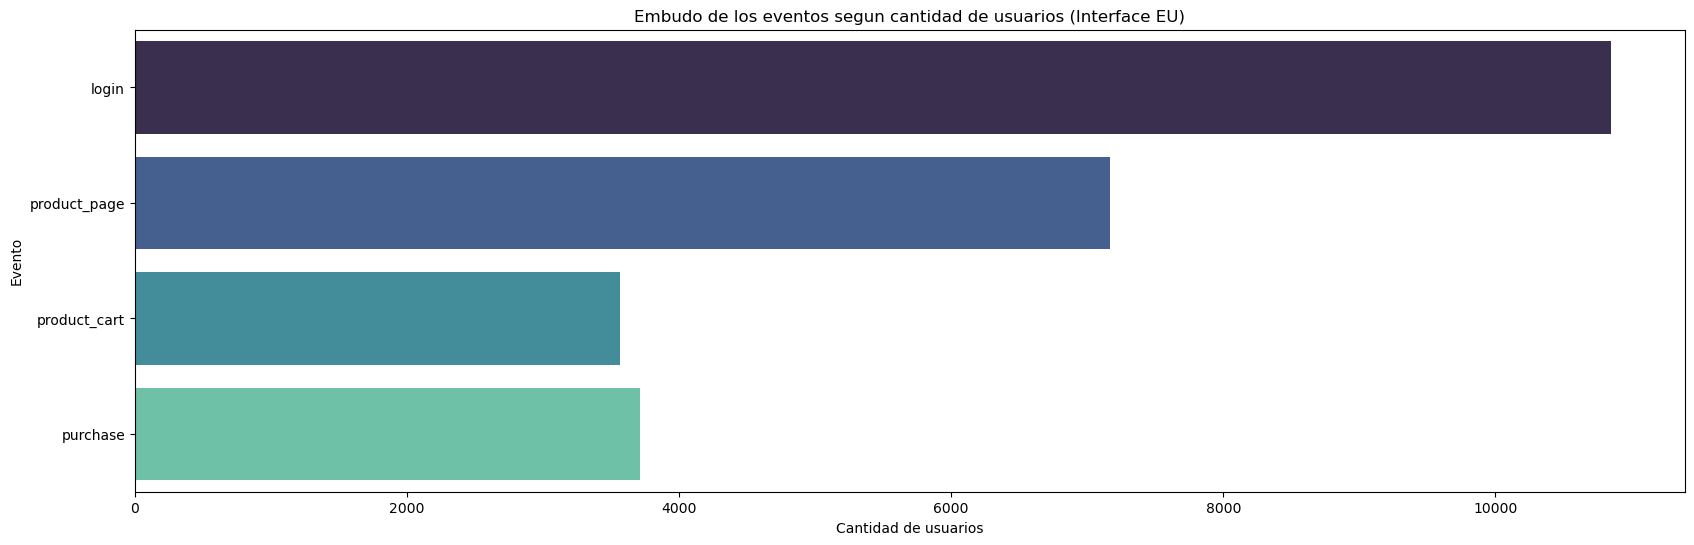

In [ ]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos
events_cohort_total_eu = events_cohort_eu.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=events_cohort_total_eu, y='event_name', x='user_id', palette='mako', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios')
plt.title('Embudo de los eventos segun cantidad de usuarios (Interface EU)')
sns.color_palette('tab10')
plt.show()

Mayor cantidad de usuarios en 'product_cart' que en el evento 'purchase'

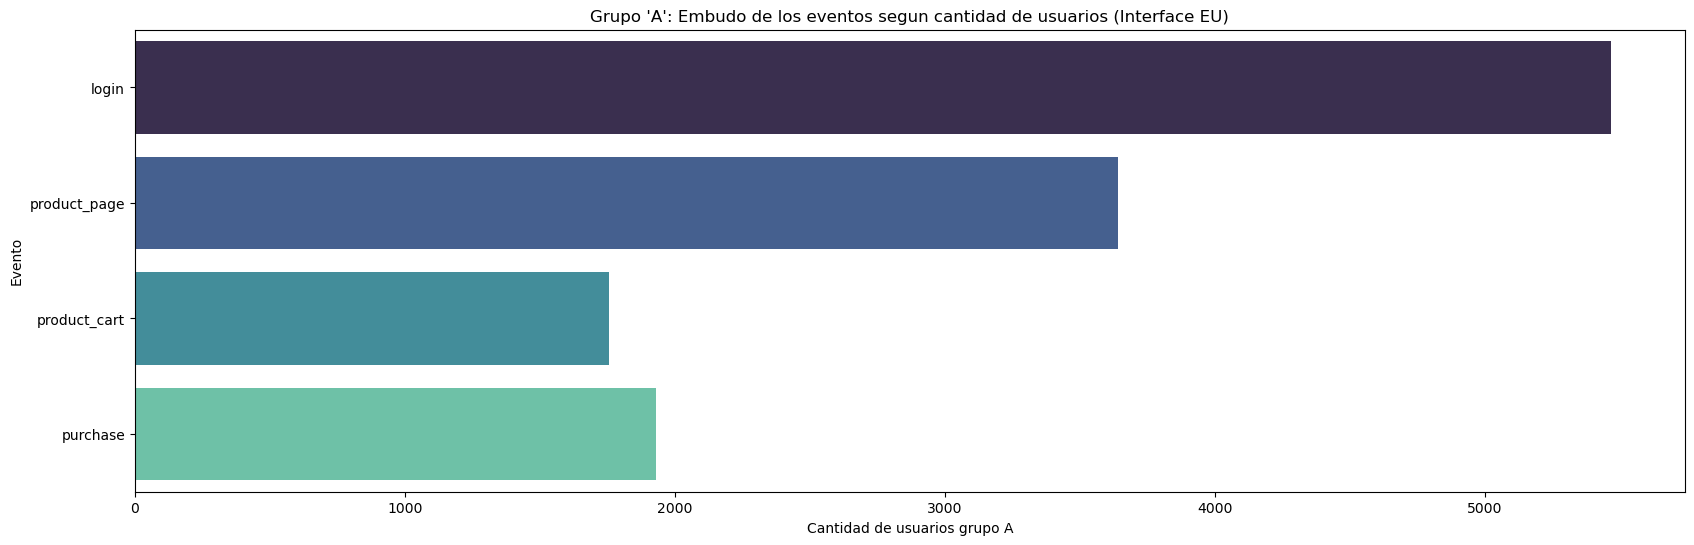

In [ ]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos

cohort_events_A_eu = events_A_eu.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=cohort_events_A_eu, y='event_name', x='user_id', palette='mako', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo A')
plt.title('Grupo \'A\': Embudo de los eventos segun cantidad de usuarios (Interface EU)')
sns.color_palette('tab10')
plt.show()

Mayor cantidad de usuarios en 'product_cart' que en el evento 'purchase'

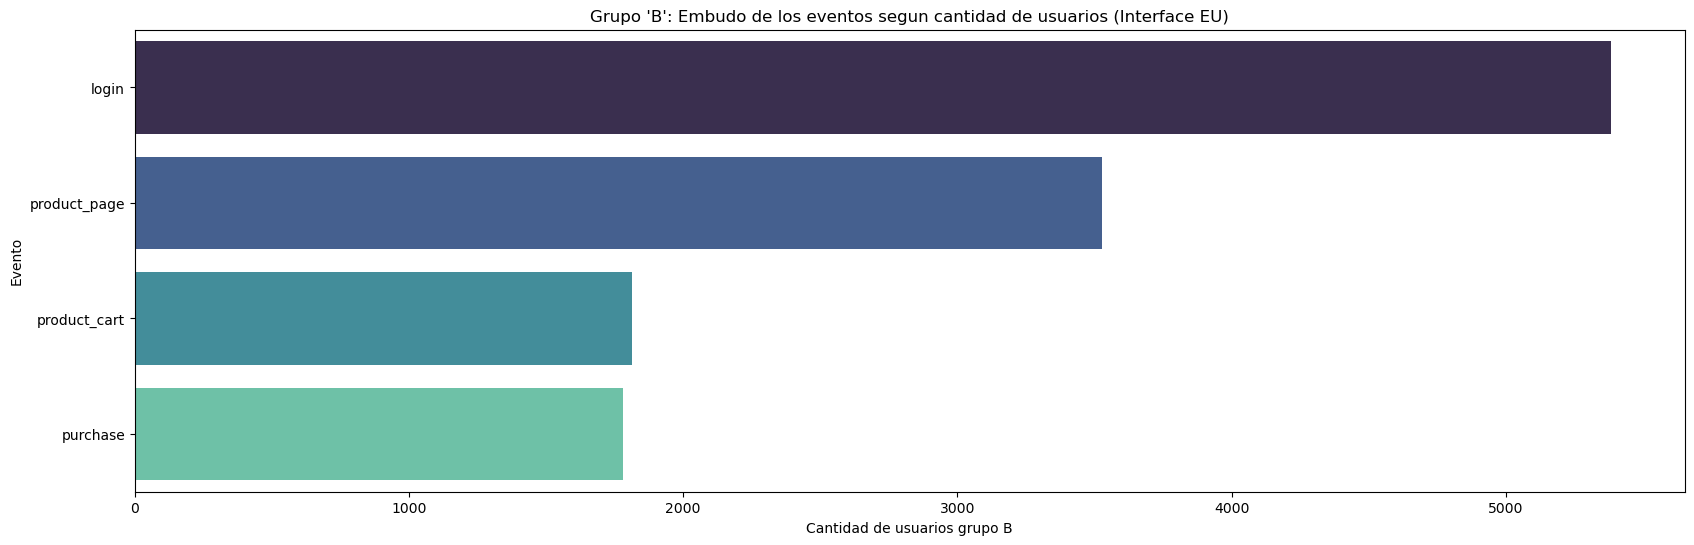

In [ ]:
#Observamos cantidad de usuarios únicos en cada evento y sumar la columna details para ver el total  ingresos

cohort_events_B_eu = events_B_eu.groupby(['event_name']).agg({'user_id':'nunique', 'details': 'sum'}).reset_index().reindex(index=[0,2,1,3])

#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=cohort_events_B_eu, y='event_name', x='user_id', palette='mako', hue='event_name')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo B')
plt.title('Grupo \'B\': Embudo de los eventos segun cantidad de usuarios (Interface EU)')
sns.color_palette('tab10')
plt.show()

In [ ]:
#calculamos cantidad total de usuarios para hacer calculos posteriores:
total_users = events_cohort_eu['user_id'].nunique()

users_A = events_A_eu['user_id'].nunique()
users_B = events_B_eu['user_id'].nunique()

#Calculamos la proporcioón de usuarios que se registraron en cada evento al menos una vez
events_cohort_total_eu['user_%'] = (events_cohort_total_eu['user_id'] / total_users* 100).round(2)
cohort_events_A_eu['user_%'] = (cohort_events_A_eu['user_id'] / users_A* 100).round(2)
cohort_events_B_eu['user_%'] = (cohort_events_B_eu['user_id'] / users_B* 100).round(2)
#Teniendo en cuenta cómo se suceden los eventos, calculamos la tasa de conversion de clientes en cada grupo

events_cohort_total_eu['convert_%'] = ((events_cohort_total_eu['user_id'] / events_cohort_total_eu['user_id'].shift(1))*100).round(2)

#Calculamos la tasa de conversión de usuarios de evento a evento por  cada grupo de prueba
cohort_events_A_eu['convert_%'] = ((cohort_events_A_eu['user_id'] / cohort_events_A_eu['user_id'].shift(1))*100).round(2)
cohort_events_B_eu['convert_%'] = ((cohort_events_B_eu['user_id'] / cohort_events_B_eu['user_id'].shift(1))*100).round(2)


#calculamos la cantidad de usuarios que entre evento y evento se perdieron
events_cohort_total_eu['dropped_%'] = 100 - events_cohort_total_eu['convert_%']
cohort_events_A_eu['dropped_%'] = 100 - cohort_events_A_eu['convert_%']
cohort_events_B_eu['dropped_%'] = 100 - cohort_events_B_eu['convert_%']

print('Eventos y usuarios totales en la prueba Interface EU:')
display(events_cohort_total_eu)
print('Grupo A:')
display(cohort_events_A_eu)
print('Grupo B:')
display(cohort_events_B_eu)

Eventos y usuarios totales en la prueba Interface EU:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,10849,0.00,99.99,NaN,NaN
2,product_page,7166,0.00,66.05,66.05,33.95
1,product_cart,3568,0.00,32.88,49.79,50.21
3,purchase,3713,275613.56,34.22,104.06,-4.06


Grupo A:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,5466,0.00,99.98,NaN,NaN
2,product_page,3639,0.00,66.56,66.58,33.42
1,product_cart,1756,0.00,32.12,48.26,51.74
3,purchase,1931,145954.26,35.32,109.97,-9.97


Grupo B:


,event_name,user_id,details,user_%,convert_%,dropped_%
0,login,5383,0.0,100.00,NaN,NaN
2,product_page,3527,0.0,65.52,65.52,34.48
1,product_cart,1812,0.0,33.66,51.38,48.62
3,purchase,1782,129659.3,33.10,98.34,1.66


En las pruebas realizadas en 'Interface EU' se observan más de 10.000 usuarios que fueron parte de esta prueba. Estos se ven distribuídos equitativamente entre los grupos de control y de prueba contando cada uno con más de 5000 usuarios.

El grupo de control tiene la misma 'particularidad' que en el grupo A de la prueba 'Recommender System', de tener mayor conversión y cantidad de usuarios en la etapa purchase a comparación de la etapa previa 'product_cart'.

In [ ]:
#confirmamos que los usuarios en el grupo A y B son únicos y no se repiten en ambos grupos
users_unique_A_eu = cohort_events_A_eu['user_id'].unique()

users_unique_B_eu = cohort_events_B_eu['user_id'].unique()

if users_unique_A_eu in users_unique_B_eu:
    print('Hay usuarios que participaron en ambos grupos de prueba')
else:
    print('No hay usuarios que participaron en ambos grupos de prueba')

No hay usuarios que participaron en ambos grupos de prueba


event_name  login  product_page  product_cart  purchase
date                                                   
2020-12-07    903           586           270       309
2020-12-08    996           665           310       340
2020-12-09   1002           651           343       337
2020-12-10   1076           731           366       378
2020-12-11   1114           752           361       376
2020-12-12   1486           971           528       497
2020-12-13   1690          1121           571       592
2020-12-14   2068          1326           664       725
2020-12-15   1875          1223           614       621
2020-12-16   1716          1117           566       617
2020-12-17   1774          1160           574       607
2020-12-18   1838          1177           600       604
2020-12-19   1865          1230           633       632
2020-12-20   2076          1344           679       729
2020-12-21   2586          1716           875       893
2020-12-22   2298          1531           735   

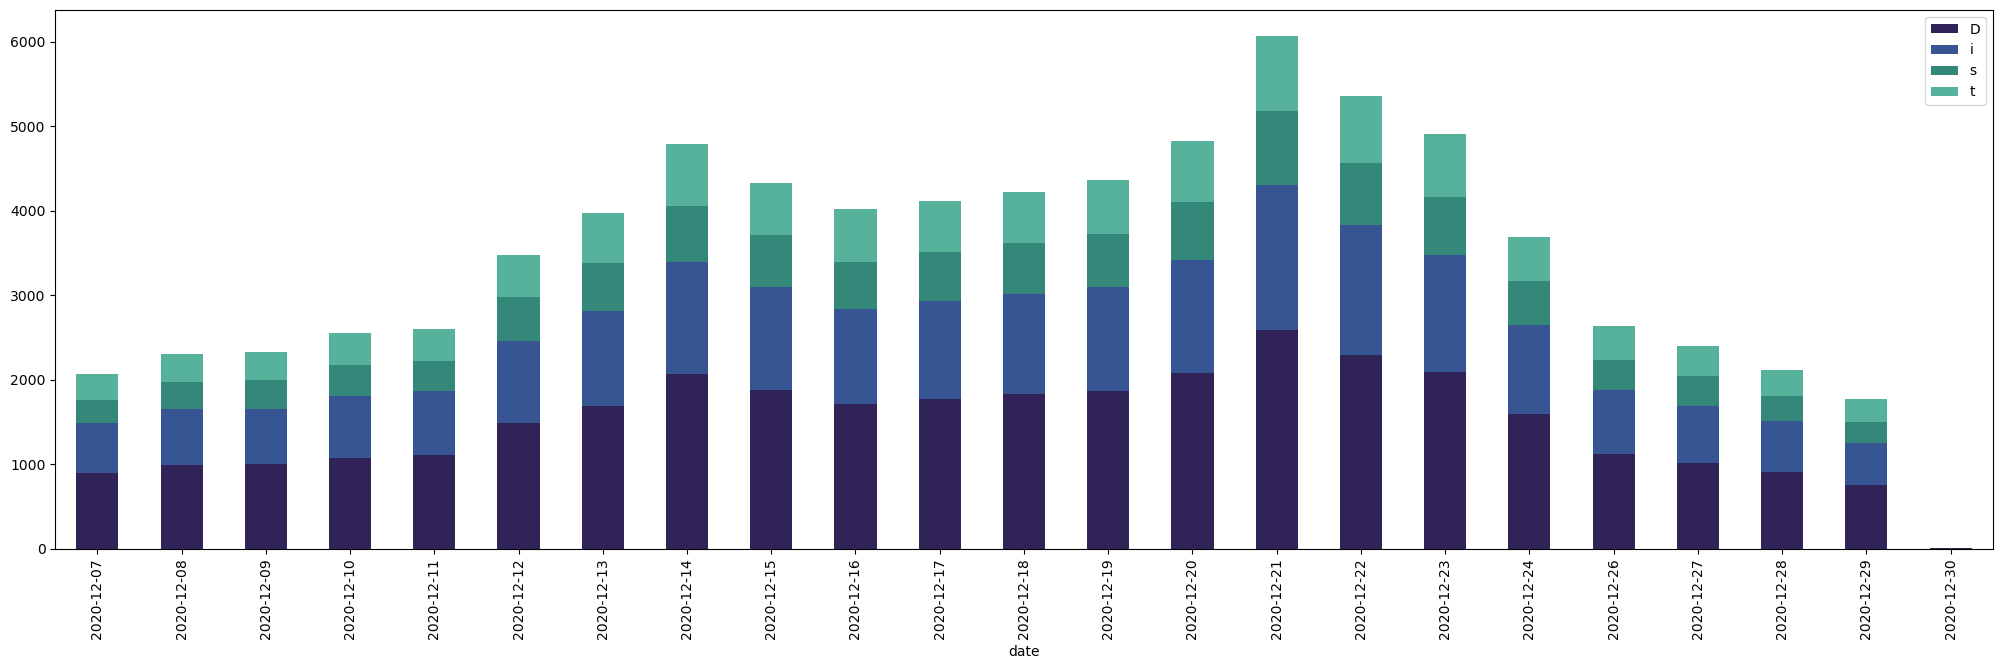

In [2874]:
#Creamos una tabla dinámica para observar cantidad de usuarios por eventos distribuidos a lo largo de los dias
events_pivot_eu = events_cohort_eu.pivot_table(index='date', columns='event_name', values='user_id', aggfunc='nunique')
events_pivot_eu = events_pivot_eu[['login', 'product_page', 'product_cart', 'purchase']]

print(events_pivot_eu)
events_pivot_eu.plot.bar(stacked=True,figsize=(25,7), color=["#302358FF", "#385593", "#2E8575F8", "#49AC94ED"])
plt.legend('Distribución de los eventos a los largo de los días en la prueba: Interface EU')
plt.show()

En la prueba Interface EU, se puede observar como va ascendentemente ganando cantidad de eventos registrados a partir del 07/12 hasta el 24 donde comienza a descender. Se pueden ver dos picos: uno el 14/12, luego desciende un poco los registros y vuelve a ascender hasta llegar a su punto máximo el 21/12.

Se observa que la división entre grupos es mas pareja a comparación de la otra prueba.

Al igual que en la prueba 'Recommender System' se observa que en el grupo de control en la etapa de 'product_card' la cantidad de registros es menor que en la etapa posterior 'purchase'.

El grupo de control tiene mayor cantidad de conversión en la etapa 'purchase' comparada con el grupo B, diferenciandose por un poco más del 2%. Esto también se debe a lo mencionado arriba de cuantos usuarios se registran en la etapa 'product_cart' y 'purchase'.

### Prueba de hipótesis

In [2875]:
#Calculamos cantidad de eventos en cada grupo para probar la hipotesis de que la cantidad de los mismos son potencialmente iguales.
#Vamos a utilizar las variables events_A/B_system/EU donde tenemos guardada la cantidad de usuarios, eventos registrados (fecha y nombre) y los detalles.

#agrupo por eventos
sampleA_system = events_A_system .groupby('event_name').size().reset_index(name='amount').sort_values(by='amount', ascending=False).reindex(index=[0,2,1,3])
sampleB_system = events_B_system.groupby('event_name').size().reset_index(name='amount').sort_values(by='amount', ascending=False).reindex(index=[0,2,1,3])

sampleA_eu = events_A_eu.groupby('event_name').size().reset_index(name='amount').sort_values(by='amount', ascending=False).reindex(index=[0,2,1,3])
sampleB_eu = events_B_eu.groupby('event_name').size().reset_index(name='amount').sort_values(by='amount', ascending=False).reindex(index=[0,2,1,3])

#calculamos proporción de éxito para cada grupo
sampleA_system['conv_acum'] = (sampleA_system['amount'] / sampleA_system['amount'][0]).round(2)
sampleB_system['conv_acum'] = (sampleB_system['amount'] / sampleB_system['amount'][0] ).round(2)
sampleA_eu['conv_acum'] = (sampleA_eu['amount'] / sampleA_eu['amount'][0]).round(2)
sampleB_eu['conv_acum'] = (sampleB_eu['amount'] / sampleB_eu['amount'][0]).round(2)

print(f"""
    Test Recommender System:
    Grupo A:
    {sampleA_system}
    
    Grupo B:
    {sampleB_system}
    
    Test Interface EU:
    Grupo A:
    {sampleA_eu}
    
    Grupo B:
    {sampleB_eu}
    """)


    Test Recommender System:
    Grupo A:
         event_name  amount  conv_acum
0         login    8272       1.00
2  product_page    5328       0.64
1  product_cart    2482       0.30
3      purchase    2545       0.31

    Grupo B:
         event_name  amount  conv_acum
0         login    2565       1.00
2  product_page    1374       0.54
1  product_cart     678       0.26
3      purchase     665       0.26

    Test Interface EU:
    Grupo A:
         event_name  amount  conv_acum
0         login   17122       1.00
2  product_page   11341       0.66
1  product_cart    5541       0.32
3      purchase    6074       0.35

    Grupo B:
         event_name  amount  conv_acum
0         login   16746       1.00
2  product_page   10918       0.65
1  product_cart    5617       0.34
3      purchase    5570       0.33
    


Observación general: no se observa una conversión acumulada superior en el grupo B que en el de control en ninguna de las dos pruebas A/B (Recommender System / Eu interface)

In [2876]:
#Checkeamos si hay una diferencia estadísticamente significativa entre las muestras de la prueba Recommender System.
def dif_estadistica_s (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pA_system = sampleA_system['conv_acum'][i] 
    pB_system = sampleB_system['conv_acum'][i]
    
    ## proporción de éxito en los grupos A - B unidos
    p_combined_system = ((sampleA_system['amount'][i] + sampleB_system['amount'][i]) / (sampleA_system['amount'][0] + sampleB_system['amount'][0])).round(2)

    #la diferencia entre las proporciones de los grupos A - B
    difference_system = pA_system - pB_system

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_s = difference_system / mth.sqrt(p_combined_system * (1- p_combined_system) * (1/sampleA_system['amount'][0] + 1/sampleB_system['amount'][0]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 

    p_value_S_bi = (1- distr.cdf(abs(z_value_s))) * 2
    
    print('p-value : ', p_value_S_bi)

    if (p_value_S_bi < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Login y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: login y product_page
dif_estadistica_s(2, 'Product Page')
#comparamos si hay diferencia significativa entre los grupos del evento: login y product_cart
dif_estadistica_s(1, 'Product Cart')
#comparamos si hay diferencia significativa entre los grupos del evento: login y purchase
dif_estadistica_s(3, 'Purchase')


p-value :  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y Product Page
p-value :  9.597304968900211e-05
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y Product Cart
p-value :  1.380072850665215e-06
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y Purchase


In [2877]:
#Checkeamos si hay una diferencia estadísticamente significativa entre las muestras de la prueba Interface EU.
def dif_estadistica_eu (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pA_eu = sampleA_eu['conv_acum'][i] 
    pB_eu = sampleB_eu['conv_acum'][i]
    
    ## proporción de éxito en los grupos A - B unidos
    p_combined_eu = ((sampleA_eu['amount'][i] + sampleB_eu['amount'][i]) / (sampleA_eu['amount'][0] + sampleB_eu['amount'][0])).round(2)

    #la diferencia entre las proporciones de los grupos A - B
    difference_eu = pA_eu - pB_eu

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_eu = difference_eu / mth.sqrt(p_combined_eu * (1- p_combined_eu) * (1/sampleA_eu['amount'][0] + 1/sampleB_eu['amount'][0]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 

    p_value_E_bi = (1- distr.cdf(abs(z_value_eu))) * 2
    

    print('p-value : ', p_value_E_bi)

    if (p_value_E_bi < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Login y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: login y product_page
dif_estadistica_eu(2, 'Product Page')
#comparamos si hay diferencia significativa entre los grupos del evento: login y product_cart
dif_estadistica_eu(1, 'Product Cart')
#comparamos si hay diferencia significativa entre los grupos del evento: login y purchase
dif_estadistica_eu(3, 'Purchase')

p-value :  0.05209523190177556
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Login y Product Page son diferentes
p-value :  9.093971347162721e-05
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y Product Cart
p-value :  0.00010245972416411675
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Login y Purchase


## Conclusión

Luego de los estudios realizados en este trabajo hay algunas observaciones que quiero aclarar:

- se habla de una prueba A/B llamada 'recommender_system_test', pero no hay mención de la prueba 'Interface_eu_test'. Sin embargo se han analizado ambas en conjunto y por separado.
- La cantidad de participantes en la prueba que se estimaban eran 6000, en recommender test la cantidad de usuarios que participan es de 3675, mientras que en Interface_EU es de 10850.
- Los usuarios que participan en la prueba Recommender System son de varias regiones (4), pero los de Inerface EU solo de Europa.
- La manera en la que están divididos los grupos en las pruebas Recommender System es desproporcional, teniendo 3 veces mayor cantidad de usuarios en el grupo de control que en el grupo B. En Interface Eu se ve mayor equidad en la cantidad de usuarios entre ambas muestras.

Ahora bien, vamos a datos más específicos:

* Recommender system:
    * Media de eventos por usuarios: 6.
    * Anómalo todo usuario que tiene más de 18 eventos registrados.
    * El grupo A muestra mayor cantidad de usuarios en la etapa final del proceso (Purchase) que en su antecesora (purchase_cart) por alguna razón, puede deberse a que de la etapa product_page, puedan pasar a comprar directamente o que accedan desde alguna otra plataforma directamente a la etapa de compra.
    * La conversión de una etapa a la otra es mayor en grupo A que en el B, parte se debe a lo mencionado en el punto anterior. 
    * La pérdida y la cantidad de usuarios que pasan de una etapa a otra es mayor en el grupo A que en el B.
    * En la actividad de los eventos distribuidos a lo largo de 3 semanas, se observa que 10 días previo a navidad la actividad crece con fuerza llegando a su pico más alto el 21/12, y posterior a dicha fecha comienza a decrecer.
    * Con respecto a los resultados obtenidos en las pruebas A/B, se observa lo que ya veníamos anticipando que hay diferencias entre el grupo de control y el de prueba.

* Interface EU:
    * Media de eventos por usuario es de 7. 
    * Anómalos los usuarios con más de 20 eventos.
    * El grupo de control tiene mayor cantidad de usuarios, al igual que en las pruebas Recommender System, en la etapa final Purchase, que en su etapa previa: Product Cart.
    * Cuando comparamos usuarios y eventos totales podemos ver que la conversión de usuarios es mayor en la etapa final del grupo A por lo mencionado arriba. Esto afecta los demás resultados que se observan en la misma tabla.
    * En cuanto a la como se distribuye la actividad de los eventos a lo largo de los días, se observan dos olas: una con su pico más alto el 14/12, luego desciende levemente y alcanza su pico máximo el 21/12, luego comienza a decrecer.
    * Los resultados obtenidos en las pruebas A/B solo en la etapa 'Product Page' no se rechazó la etapa nula, como se estuvo observando previamente se observan diferencias significativas entre los grupos en las etapas que le prosiguen a la misma.


Como conclusión general, estas pruebas tuvieron lugar durante la época navideña, que se ve reflejada en cómo afecta la actividad de los usuarios cerca a dicha fecha. Sin embargo, no se puede observar que en cada etapa del embudo haya un crecimiento del 10% en el grupo de prueba, ya que el grupo de control demostró mayor porcentaje de eventos registrados en ambas pruebas.

